## Image Classification: Cheetahs and Leopards

Sticking with the big cat theme, let's try a slightly harder classification project: determinig the difference between the leopard and the cheetah! 

### Steps
1. Download data
2. Create an `ImageDataBunch`
    - Specifying the % of validation data, image size and transformations
3. View the data
    - check size, classes and some sample images
4. Create a CNN learner
    - Using the data, choice of model (resnet34 most likely!)
5. `fit_one_cycle`
    - Run for a few epochs to check performance
6. Use `lr_find()` to find a better learning rate
    - Use a slice
7. Save, unfreeze and train the model with new LR
8. Interpret the results

In [1]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

## Download some data

In [2]:
path = Path.cwd()/'data'

In [ ]:
search_terms = ['cheetah', 'leopard']

for cat in search_terms:
    download_google_images(path, cat, size='>1024*768', n_images=100)

In [3]:
data = ImageDataBunch.from_folder(path, 
                      valid_pct=.3, 
                      size=128, 
                      bs=32,
                      ds_tfms=get_transforms()).normalize(imagenet_stats)

In [4]:
data.classes, data.c

(['cheetah', 'leopard'], 2)

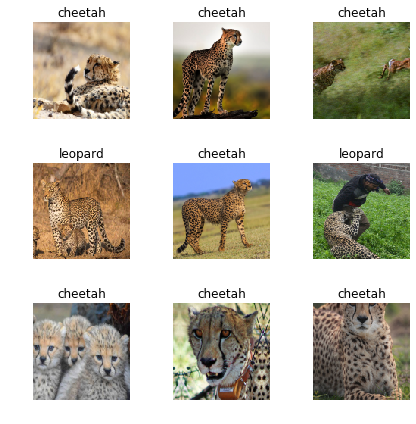

In [5]:
data.show_batch(rows=3, figsize=(6,6))

In [6]:
pd.value_counts(data.train_ds.y)

cheetah    60
leopard    58
dtype: int64

In [7]:
pd.value_counts(data.valid_ds.y)

cheetah    30
leopard    20
dtype: int64

### Build a CNN learner

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.836965,0.824810,0.560000,0.440000,00:19
1,0.722595,0.297639,0.880000,0.120000,00:20
2,0.573442,0.301074,0.880000,0.120000,00:17
3,0.495935,0.352553,0.840000,0.160000,00:19


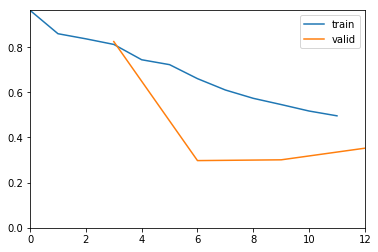

In [8]:
learn = cnn_learner(data, 
                    models.resnet34, 
                    metrics=[accuracy, error_rate],
                   callback_fns=ShowGraph)

# you can use this instead of adding the ShowGraph callback
# learn.recorder.plot_losses()

learn.fit_one_cycle(cyc_len=4)

84% accuracy for a fairly difficult problem is pretty good. Let's see if we can imporve this

In [9]:
learn.save('cats_stage_1')

learn.unfreeze()

learn.lr_find() 
# I don't understand why lr_find randomly pics no. of epochs
# this cycle chose 34 epochs??

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


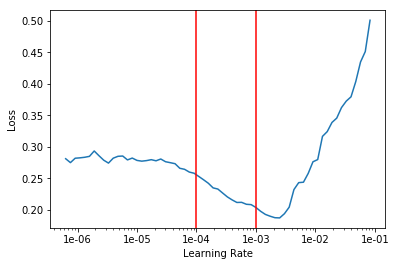

In [12]:
learn.recorder.plot()
plt.axvline(x=1e-3, color='red');
plt.axvline(x=1e-4, color='red');

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.304030,0.386361,0.820000,0.180000,00:26
1,0.296550,0.464128,0.840000,0.160000,00:23
2,0.260878,0.620305,0.800000,0.200000,00:23
3,0.224610,0.602530,0.820000,0.180000,00:23
4,0.194224,0.315924,0.900000,0.100000,00:24
5,0.185804,0.347534,0.880000,0.120000,00:24
6,0.164163,0.350068,0.860000,0.140000,00:23
7,0.150962,0.305271,0.900000,0.100000,00:22
8,0.135833,0.297066,0.900000,0.100000,00:23
9,0.120803,0.292470,0.900000,0.100000,00:24


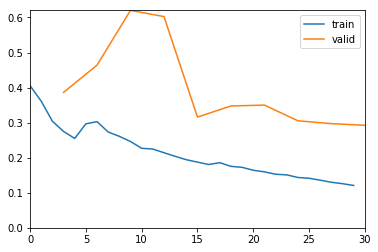

In [13]:
learn.fit_one_cycle(10, max_lr=slice(1e-4,1e-3))

In [14]:
learn.save('cats_stage_2')

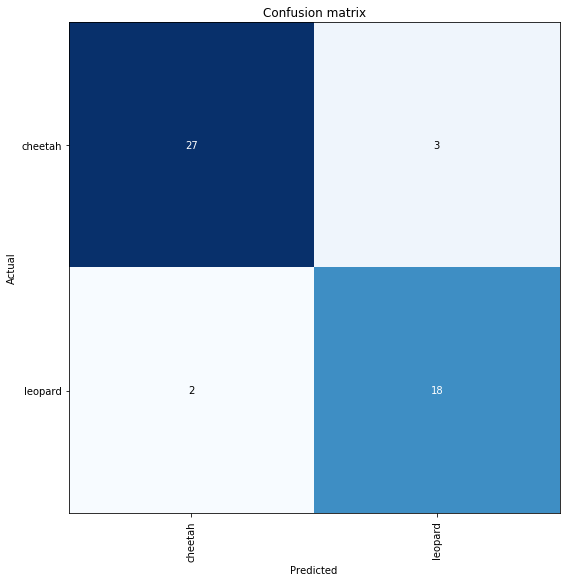

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

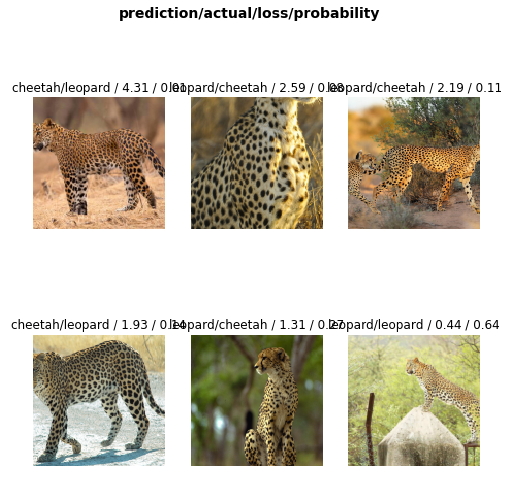

In [18]:
interp.plot_top_losses(k=6, figsize=(8,8), heatmap=False)

The model doesn't seem to be great at discerning between the two animals when the face is not very clear and when the animal is pictured from a side angle, from a distance. Some reasons could be related to the distance and angle, which obscures some of the key differences between markings and coat.

**Cheetahs** have very unique 'tears' on their faces which leopards do not have. Cheetahs also have single, clear dark/black spots which are separated from other spots on the cat's body.

**Leopards** have smaller, irregular shaped spots that group together in irregular shapes, these are called rosettes.

From a distance, these subtle characteristics could be mistaken, but 90% isn't bad.

## Putting the model in production

In [19]:
learn.export()

In [20]:
defaults.device = torch.device('cpu')

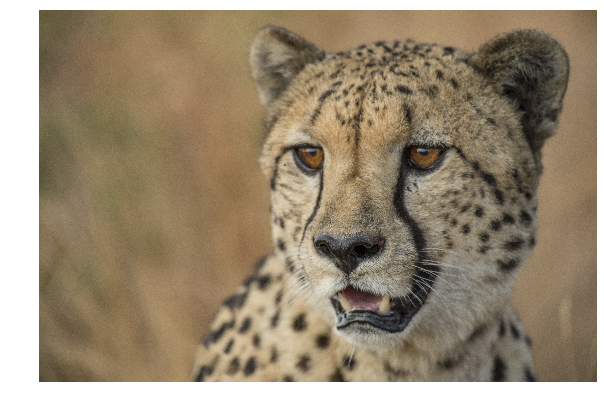

In [32]:
img = open_image(path/'cheetah'/'00000024.jpg')
img.show(figsize=(10,10))

In [33]:
learn = load_learner(path)

In [34]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category cheetah

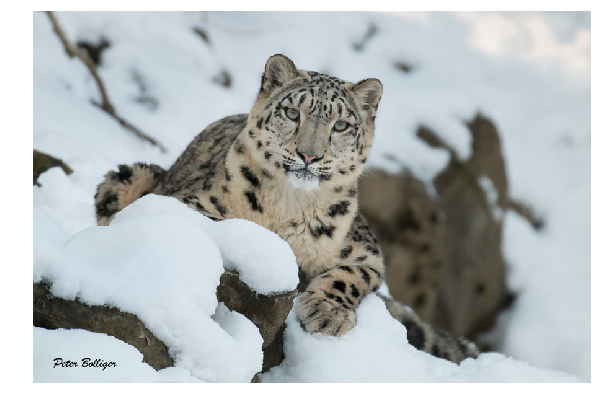

In [35]:
img = open_image(path/'leopard'/'00000054.jpg')
img.show(figsize=(10,10))

In [25]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category leopard

In [28]:
# loop through a few images and test
images = ['cheetah/00000070.jpg','cheetah/00000018.jpg','cheetah/00000032.jpg','cheetah/00000045.jpg','cheetah/00000027.jpg','cheetah/00000044.jpg',
         'leopard/00000012.jpg','leopard/00000026.jpg','leopard/00000054.jpg','leopard/00000070.jpg','leopard/00000046.jpg','leopard/00000019.jpg']


for image in images:
    img = open_image(path/image)
    pred_class,pred_idx,outputs = learn.predict(img)
    print(pred_class,image)

cheetah cheetah/00000070.jpg
cheetah cheetah/00000018.jpg
cheetah cheetah/00000032.jpg
cheetah cheetah/00000045.jpg
cheetah cheetah/00000027.jpg
cheetah cheetah/00000044.jpg
leopard leopard/00000012.jpg
leopard leopard/00000026.jpg
leopard leopard/00000054.jpg
leopard leopard/00000070.jpg
leopard leopard/00000046.jpg
leopard leopard/00000019.jpg


Well done computer!!